In [2]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder


In [3]:
conn = sqlite3.connect('formula1.db')
query = """
SELECT
    c.clasificacion_id,
    c.piloto_id,
    c.tiempo_q1,
    c.tiempo_q2,
    c.tiempo_q3,
    cir.longitud_km,
    cir.curvas,
    car.condiciones_climaticas,
    car.temperatura_ambiente,
    car.temperatura_pista,
    car.humedad,
    res.mejor_vuelta AS tiempo_mejor_vuelta
FROM clasificacion AS c
JOIN carrera   AS car ON c.carrera_id   = car.carrera_id
JOIN circuito  AS cir ON car.circuito_id = cir.circuito_id
JOIN resultado AS res ON c.clasificacion_id = res.resultado_id
WHERE res.mejor_vuelta IS NOT NULL;
"""

df = pd.read_sql_query(query, conn)
conn.close()

In [4]:
df = pd.get_dummies(df, columns=['condiciones_climaticas'], drop_first=True)
df = df.dropna()
label_encoder = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoder[column] = le

In [5]:
X = df.drop(columns=['tiempo_mejor_vuelta', 'clasificacion_id', 'piloto_id'])
y = df['tiempo_mejor_vuelta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

Tamaño del conjunto de entrenamiento: (120, 9)
Tamaño del conjunto de prueba: (30, 9)


In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [7]:
y_mean = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, y_mean)
print("Baseline MAE:", baseline_mae)

Baseline MAE: 10.838088888888883


Error Absoluto Medio (MAE): 11.29417520100044
Error Cuadrático Medio (MSE): 157.77254755503037
Raíz del Error Cuadrático Medio (RMSE): 12.56075425900174


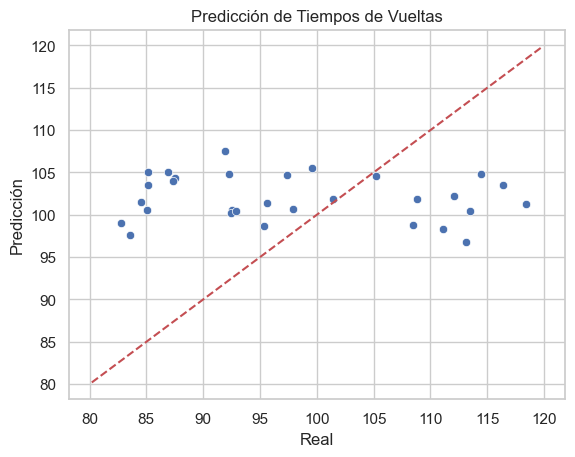

In [8]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
sns.set(style="whitegrid")
sns.scatterplot(x=y_test, y=y_pred)
pt.xlabel("Real")
pt.ylabel("Predicción")
pt.title("Predicción de Tiempos de Vueltas")
pt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
pt.show()